<a href="https://colab.research.google.com/github/AhamadAli30/Knee-Osteoarthritis/blob/main/Coronal_Classification_ResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Flatten, Dense, Dropout

In [ ]:
import os
from sklearn.model_selection import train_test_split
from shutil import copyfile

# Set the paths
dataset_dir = "/content/drive/MyDrive/cropped_mri/Coronal/Severe"
train_dir = "/content/drive/MyDrive/Coronal Classification /Train/Severe"
test_dir = "/content/drive/MyDrive/Coronal Classification /Test/Severe"
valid_dir = "/content/drive/MyDrive/Coronal Classification /Valid/Severe"

# Create directories if they don't exist
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)
os.makedirs(valid_dir, exist_ok=True)

# List all the images in your dataset
all_images = os.listdir(dataset_dir)

# Use train_test_split to split the dataset
train_images, test_valid_images = train_test_split(all_images, test_size=0.4, random_state=42)
test_images, valid_images = train_test_split(test_valid_images, test_size=0.5, random_state=42)

# Function to copy images to the respective directories
def copy_images(source_dir, destination_dir, image_list):
    for image in image_list:
        source_path = os.path.join(dataset_dir, image)
        destination_path = os.path.join(destination_dir, image)
        copyfile(source_path, destination_path)

# Copy images to the respective directories
copy_images(dataset_dir, train_dir, train_images)
copy_images(dataset_dir, test_dir, test_images)
copy_images(dataset_dir, valid_dir, valid_images)

print("Dataset split completed.")


Dataset split completed.


In [ ]:
train_dir = '/content/drive/MyDrive/Coronal Classification /Train'
test_dir = '/content/drive/MyDrive/Coronal Classification /Test'
valid_dir = '/content/drive/MyDrive/Coronal Classification /Valid'

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255,
                             rotation_range=20,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir,
                                              target_size=(200, 200),
                                              batch_size=32,
                                              class_mode='categorical',
                                              shuffle=True)

valid_generator = test_datagen.flow_from_directory(valid_dir,
                                              target_size=(200, 200),
                                              batch_size=32,
                                              class_mode='categorical',
                                              shuffle=False)

test_generator = test_datagen.flow_from_directory(test_dir,
                                              target_size=(200, 200),
                                              batch_size=32,
                                              class_mode='categorical',
                                              shuffle=False)

Found 217 images belonging to 4 classes.
Found 74 images belonging to 4 classes.
Found 73 images belonging to 4 classes.


In [ ]:
# Check batch size
for image_batch, labels_batch in train_generator:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 200, 200, 3)
(32, 4)


In [ ]:
# Check class names
class_names = train_generator.class_indices
class_names = list(class_names.keys())
print(class_names)

['Mild', 'Moderate', 'Normal', 'Severe']


In [ ]:
def get_sample_image(generator):
    images, labels = next(generator)
    image = images[0]
    label_index = np.argmax(labels[0])
    label_name = class_names[label_index]

    return image, label_name


def sample_images(generator, nrows=3, ncols=3):
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 10))

    for i in range(nrows*ncols):
        image, label_name = get_sample_image(generator)
        row = i // ncols
        col = i % ncols
        ax = axes[row][col]
        ax.imshow(image)
        ax.set_title(label_name)
        ax.axis('off')

    plt.show()

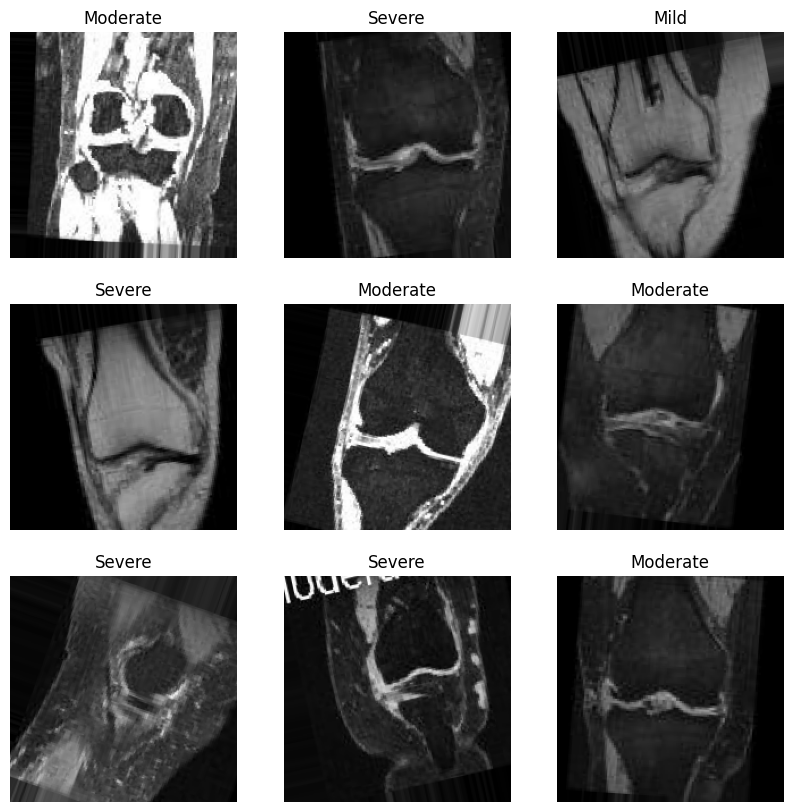

In [ ]:
sample_images(train_generator, nrows=3, ncols=3)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, ReLU, Add, GlobalAveragePooling2D, Dense

def residual_block(x, filters, kernel_size=3, stride=1):
    # Shortcut
    shortcut = x

    # First convolution
    x = Conv2D(filters, kernel_size=kernel_size, strides=stride, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    # Second convolution
    x = Conv2D(filters, kernel_size=kernel_size, strides=1, padding='same')(x)
    x = BatchNormalization()(x)

    # Shortcut connection
    if stride != 1 or shortcut.shape[-1] != filters:
        shortcut = Conv2D(filters, kernel_size=1, strides=stride, padding='valid')(shortcut)
        shortcut = BatchNormalization()(shortcut)

    x = Add()([x, shortcut])
    x = ReLU()(x)

    return x

def build_resnet(input_shape=(200, 200, 3), num_classes=4, num_blocks=[2, 2, 2, 2]):
    input_layer = Input(shape=input_shape)

    # Initial Convolution
    x = Conv2D(64, kernel_size=7, strides=2, padding='same')(input_layer)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    # Residual Blocks
    for block_num, num_filters in enumerate([64, 128, 256, 512]):
        for i in range(num_blocks[block_num]):
            stride = 2 if i == 0 and block_num != 0 else 1
            x = residual_block(x, filters=num_filters, stride=stride)

    # Global Average Pooling
    x = GlobalAveragePooling2D()(x)

    # Fully Connected Layer
    x = Dense(num_classes, activation='softmax')(x)

    # Create the model
    model = tf.keras.models.Model(inputs=input_layer, outputs=x, name='resnet')

    return model

# Create a ResNet model with default parameters
resnet_model = build_resnet()

# Display the model summary
resnet_model.summary()


Model: "resnet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 200, 200, 3)]        0         []                            
                                                                                                  
 conv2d_20 (Conv2D)          (None, 100, 100, 64)         9472      ['input_2[0][0]']             
                                                                                                  
 batch_normalization_20 (Ba  (None, 100, 100, 64)         256       ['conv2d_20[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 re_lu_17 (ReLU)             (None, 100, 100, 64)         0         ['batch_normalization_20[

In [ ]:
resnet_model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])


In [ ]:
history = resnet_model.fit(train_generator,
                    epochs=20,
                    batch_size=32,
                    validation_data=valid_generator)

Epoch 1/20
7/7 [==============================] - 255s 37s/step - loss: 4.1897 - accuracy: 0.3410 - val_loss: 129.7112 - val_accuracy: 0.2568
Epoch 2/20
7/7 [==============================] - 236s 35s/step - loss: 1.8490 - accuracy: 0.4332 - val_loss: 45.9283 - val_accuracy: 0.2568
Epoch 3/20
7/7 [==============================] - 237s 34s/step - loss: 1.2498 - accuracy: 0.4747 - val_loss: 5.9245 - val_accuracy: 0.2568
Epoch 4/20
7/7 [==============================] - 230s 33s/step - loss: 1.1851 - accuracy: 0.4793 - val_loss: 1.6048 - val_accuracy: 0.4324
Epoch 5/20
7/7 [==============================] - 229s 34s/step - loss: 1.1849 - accuracy: 0.4700 - val_loss: 3.4834 - val_accuracy: 0.3243
Epoch 6/20
7/7 [==============================] - 229s 33s/step - loss: 1.1517 - accuracy: 0.4194 - val_loss: 1.4401 - val_accuracy: 0.4189
Epoch 7/20
7/7 [==============================] - 227s 33s/step - loss: 1.1562 - accuracy: 0.4793 - val_loss: 1.8066 - val_accuracy: 0.4189
Epoch 8/20
7/7 [=

In [ ]:

def plot_history(history):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
  ax1.plot(history.history['loss'], label='loss')
  ax1.plot(history.history['val_loss'], label='val_loss')
  ax1.set_xlabel('Epoch')
  ax1.set_ylabel('categorical_crossentropy')
  ax1.grid(True)

  ax2.plot(history.history['accuracy'], label='accuracy')
  ax2.plot(history.history['val_accuracy'], label='val_accuracy')
  ax2.set_xlabel('Epoch')
  ax2.set_ylabel('Accuracy')
  ax2.grid(True)

  plt.show()

In [ ]:
result = resnet_model.evaluate(test_generator)
print("Test loss, Test accuracy : ", result)

In [ ]:
images, labels = next(test_generator)

indices = np.random.choice(range(len(images)), size=9)
images = images[indices]
labels = labels[indices]

predictions = resnet_model.predict(images)

class_names=list(test_generator.class_indices.keys())


plt.figure(figsize=(10,10))

for i in range(9):
    plt.subplot(3,3,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    image = images[i]

    if image.shape[-1] == 1:
        image = np.squeeze(image)

    plt.imshow(image)

    predicted_label = np.argmax(predictions[i])

    if predicted_label == np.argmax(labels[i]):
        color='blue'
        result_text="Correct"

    else:
        color='red'
        result_text="Incorrect"

    label_text="True: "+ class_names[np.argmax(labels[i])] + ", Pred: " + class_names[predicted_label] + f" ({result_text})"

    plt.xlabel(label_text,color=color)